# Tratamiento de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import NearestNeighbors

import geopandas as gpd
from shapely.geometry import Point
from scipy.optimize import minimize

In [2]:
# Estilo gráfico
sns.set(style="whitegrid")

In [3]:
# Importar datos

dim_tienda = pd.read_csv("/Users/abigail/Desktop/SEM VIII/DSC/Data/DIM_TIENDA.csv")
venta = pd.read_csv("/Users/abigail/Desktop/SEM VIII/DSC/Data/Venta.csv")
meta_venta = pd.read_csv("/Users/abigail/Desktop/SEM VIII/DSC/Data/Meta_venta.csv")

In [4]:
# Merge de datasets
df = venta.merge(dim_tienda, on="TIENDA_ID", how="left")
df = df.merge(meta_venta, on="ENTORNO_DES", how="left")


In [5]:
# Crear variable target
df["EXITO"] = (df["VENTA_TOTAL"] >= df["Meta_venta"]).astype(int)

In [6]:
# Mostrar estructura del dataframe final
df

,TIENDA_ID,MES_ID,VENTA_TOTAL,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET,Meta_venta,EXITO
0,813,202404,1042761.16,2.0,C,Hogar,0.00,0.0,0.0,25.99200,-98.11400,Hogar Reunión,UT_TRAFICO_VEHICULAR,TRAIN,490000.0,1
1,742,202404,604946.96,5.0,C,Base,130.38,14.0,0.0,25.79436,-100.08207,Parada Técnica,UT_TRAFICO_VEHICULAR,TRAIN,480000.0,1
2,436,202404,2486787.81,3.0,BC,Hogar,0.00,13.0,0.0,25.54982,-100.22381,Clásico,UT_TRAFICO_VEHICULAR,TRAIN,490000.0,1
3,732,202404,680701.78,5.0,C,Hogar,118.46,15.0,0.0,25.75866,-100.10849,Parada Técnica,UT_DENSIDAD,TRAIN,490000.0,1
4,282,202404,1227768.82,6.0,BC,Receso,114.00,13.0,0.0,24.85018,-99.57190,Parada Técnica,UT_CARRETERA_GAS,TRAIN,516000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21376,885,202312,1157010.83,2.0,B,Receso,110.15,10.0,9.0,25.98226,-98.09069,Oficinistas,UT_TRAFICO_PEATONAL,TRAIN,516000.0,1
21377,793,202401,699916.91,6.0,C,Base,109.40,0.0,0.0,25.19030,-99.81640,Clásico,UT_TRAFICO_VEHICULAR,TRAIN,480000.0,1
21378,53,202401,1008108.28,6.0,C,Receso,103.21,12.0,10.0,25.15216,-99.84832,Parada Técnica,UT_CARRETERA_GAS,TRAIN,516000.0,1
21379,960,202401,1324156.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# EDA

## Unicas Tiendas Agrupacion

In [7]:
# Agrupar por tienda única y SUMA 
df_tiendas = df.groupby("TIENDA_ID", as_index=False).agg({
    "VENTA_TOTAL": "sum",
    "Meta_venta": "mean",
    "MTS2VENTAS_NUM": "mean",
    "PUERTASREFRIG_NUM": "mean",
    "CAJONESESTACIONAMIENTO_NUM": "mean",
    "LATITUD_NUM": "first",
    "LONGITUD_NUM": "first",
    "EXITO": "max",  
    "PLAZA_CVE": "first",
    "NIVELSOCIOECONOMICO_DES": "first",
    "ENTORNO_DES": "first",
    "SEGMENTO_MAESTRO_DESC": "first",
    "LID_UBICACION_TIENDA": "first"
})


In [8]:
df_tiendas

,TIENDA_ID,VENTA_TOTAL,Meta_venta,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,EXITO,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA
0,1,14868578.95,490000.0,0.0,0.0,0.0,26.00177,-98.24284,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
1,2,18888956.74,490000.0,0.0,0.0,0.0,26.04198,-98.35620,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
2,3,17377229.22,490000.0,0.0,0.0,0.0,26.02464,-98.26098,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
3,4,26194774.01,490000.0,0.0,0.0,0.0,26.04326,-98.23851,1,2.0,A,Hogar,Hogar Reunión,UT_DENSIDAD
4,5,33521596.57,490000.0,0.0,0.0,0.0,26.06397,-98.26165,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,1052,23871397.26,480000.0,0.0,0.0,0.0,26.06517,-98.34480,1,2.0,B,Base,Parada Técnica,UT_DENSIDAD
1049,1053,16087199.73,490000.0,0.0,0.0,0.0,26.04132,-98.29259,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
1050,1054,32791182.88,490000.0,0.0,0.0,0.0,26.09605,-98.29327,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD
1051,1055,21302238.72,490000.0,0.0,0.0,0.0,26.01132,-98.38140,1,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD


## Tiendas con 0mt2

In [9]:
# Filtramos las tiendas con 0 m2
tiendas_mt2_cero = df[df["MTS2VENTAS_NUM"] == 0]

# Extraemos IDs únicos
tiendas_unicas_cero = tiendas_mt2_cero["TIENDA_ID"].nunique()

print(f"Número de tiendas únicas con 0 m2: {tiendas_unicas_cero}")


Número de tiendas únicas con 0 m2: 264


In [10]:
# Mostrar los IDs únicos
tiendas_unicas_lista = tiendas_mt2_cero["TIENDA_ID"].unique()
tiendas_unicas_lista.sort()
print("Tiendas con 0 m²:")
print(tiendas_unicas_lista)


Tiendas con 0 m²:
[   1    2    3    4    5    6    7    8    9   11   12   13   14   15
   16   17   18   19   43   99  101  102  103  104  105  106  107  108
  109  111  112  119  122  143  147  149  151  158  159  165  167  174
  176  177  179  184  196  242  349  367  429  436  442  443  444  445
  452  471  472  477  485  486  487  488  489  491  492  496  497  498
  499  501  504  505  508  511  514  515  516  517  518  521  522  523
  524  525  526  527  528  529  532  537  538  539  542  543  544  545
  546  547  548  551  552  553  554  555  556  565  566  567  569  572
  573  577  578  579  581  584  588  595  604  605  606  613  614  615
  617  618  619  621  622  623  624  625  626  627  628  629  632  637
  638  648  654  655  656  657  658  659  662  672  685  686  692  693
  695  697  699  708  709  712  713  715  718  719  721  723  724  725
  727  734  737  741  744  745  747  748  751  755  756  757  758  759
  761  762  763  764  768  774  776  778  779  782  784  78

## Estadisticas

In [11]:
# CORRELACION CON EXITO
correlaciones = df_tiendas.corr(numeric_only=True)
print(correlaciones["EXITO"].sort_values(ascending=False))


EXITO                         1.000000
LATITUD_NUM                   0.209827
PUERTASREFRIG_NUM             0.154138
MTS2VENTAS_NUM                0.136797
CAJONESESTACIONAMIENTO_NUM    0.092704
VENTA_TOTAL                   0.059198
PLAZA_CVE                    -0.012724
TIENDA_ID                    -0.034954
Meta_venta                   -0.078326
LONGITUD_NUM                 -0.207913
Name: EXITO, dtype: float64


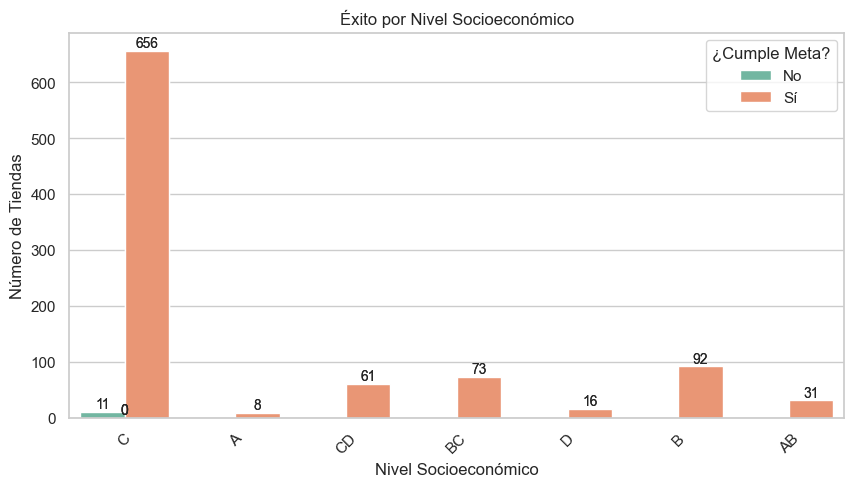

In [12]:
# Nivel Socioeconomico y exitos
plt.figure(figsize=(10,5))
sns.countplot(data=df_tiendas, x="NIVELSOCIOECONOMICO_DES", hue="EXITO", palette="Set2")
plt.title("Éxito por Nivel Socioeconómico")
plt.xticks(rotation=45)
plt.xlabel("Nivel Socioeconómico")
plt.ylabel("Número de Tiendas")
ax = sns.countplot(data=df_tiendas, x="NIVELSOCIOECONOMICO_DES", hue="EXITO", palette="Set2")
for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    ax.text(x + width / 2, height + 1, f"{int(height)}", ha='center', va='bottom', fontsize=10)
plt.legend(title="¿Cumple Meta?", labels=["No", "Sí"])
plt.show()

# La suma total de ventas por tienda


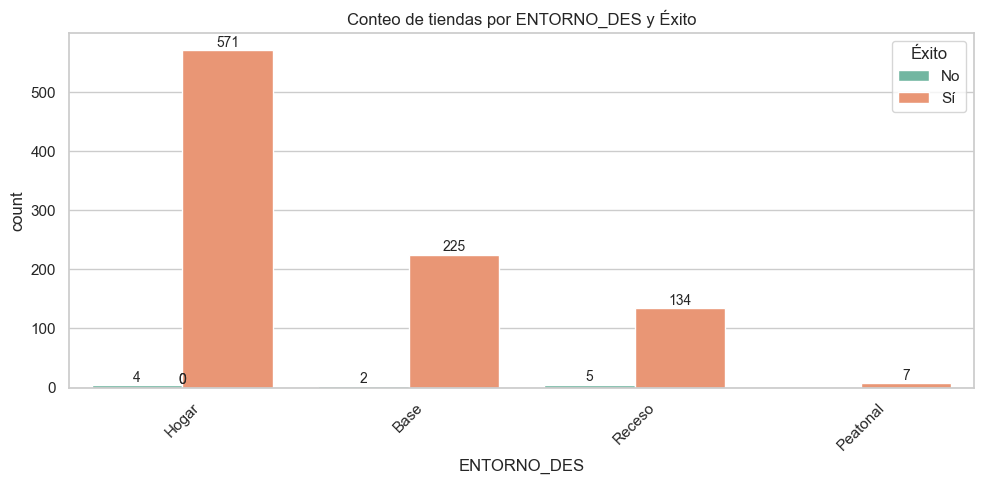

In [13]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df_tiendas, x="ENTORNO_DES", hue="EXITO", palette="Set2")
plt.title("Conteo de tiendas por ENTORNO_DES y Éxito")
plt.xticks(rotation=45)
plt.legend(title="Éxito", labels=["No", "Sí"])

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    ax.text(x + width / 2, height + 1, f"{int(height)}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


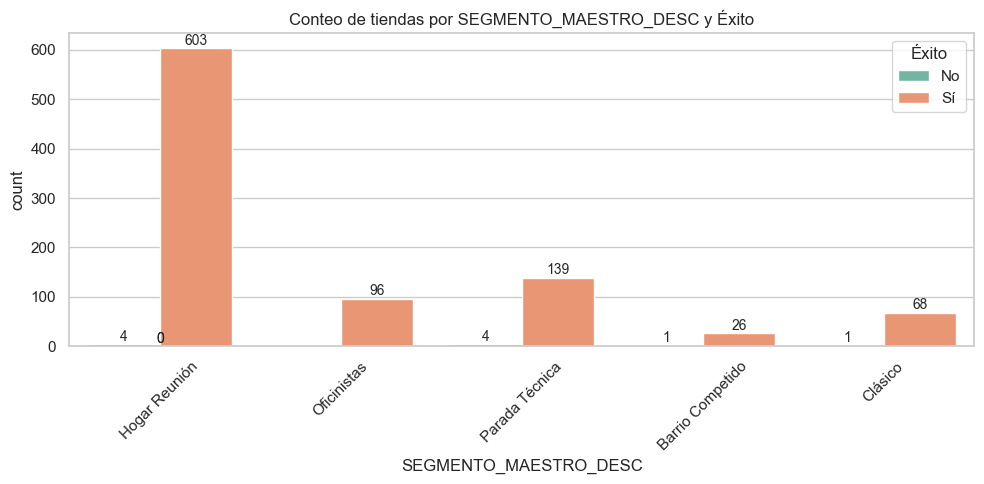

In [14]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df_tiendas, x="SEGMENTO_MAESTRO_DESC", hue="EXITO", palette="Set2")
plt.title("Conteo de tiendas por SEGMENTO_MAESTRO_DESC y Éxito")
plt.xticks(rotation=45)
plt.legend(title="Éxito", labels=["No", "Sí"])

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    ax.text(x + width / 2, height + 1, f"{int(height)}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

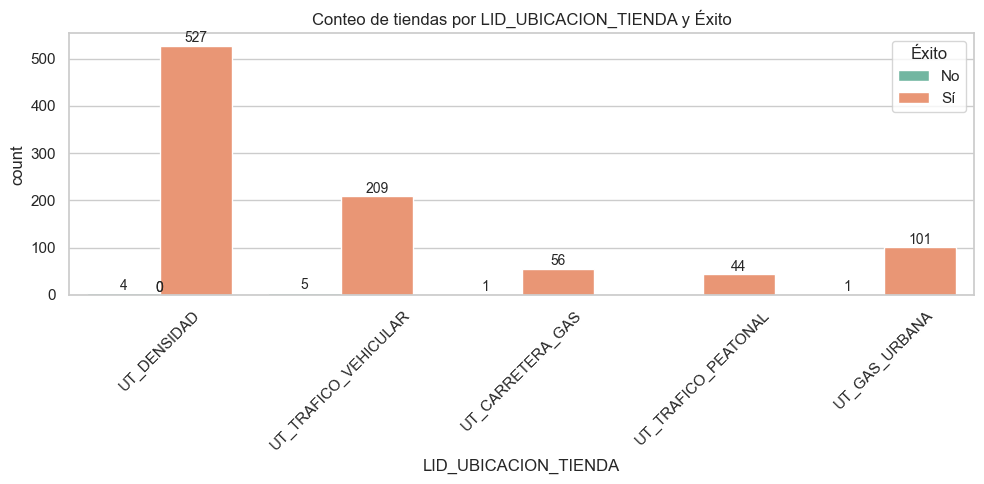

In [15]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=df_tiendas, x="LID_UBICACION_TIENDA", hue="EXITO", palette="Set2")
plt.title("Conteo de tiendas por LID_UBICACION_TIENDA y Éxito")
plt.xticks(rotation=45)
plt.legend(title="Éxito", labels=["No", "Sí"])

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    ax.text(x + width / 2, height + 1, f"{int(height)}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

<Axes: xlabel='MTS2VENTAS_NUM', ylabel='Density'>

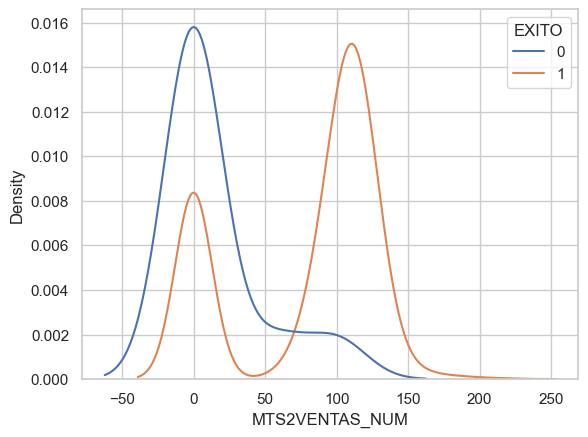

In [16]:
sns.kdeplot(data=df_tiendas, x="MTS2VENTAS_NUM", hue="EXITO", common_norm=False)


<Axes: xlabel='CAJONESESTACIONAMIENTO_NUM', ylabel='Density'>

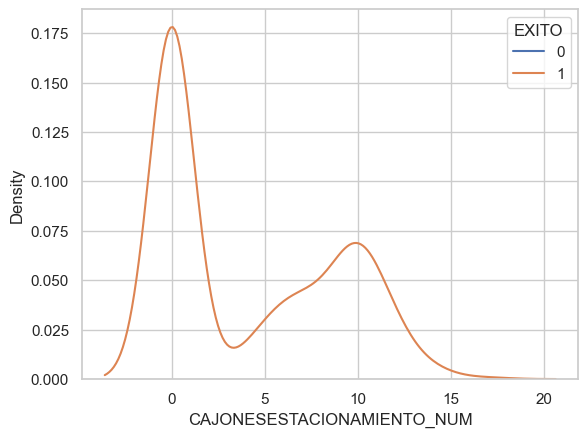

In [17]:
sns.kdeplot(data=df_tiendas, x="CAJONESESTACIONAMIENTO_NUM", hue="EXITO", common_norm=False)

<Axes: xlabel='PUERTASREFRIG_NUM', ylabel='Density'>

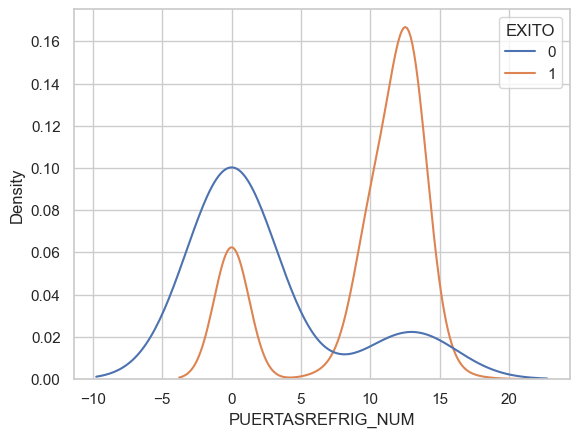

In [18]:
sns.kdeplot(data=df_tiendas, x="PUERTASREFRIG_NUM", hue="EXITO", common_norm=False)

### Proporcion sankey

In [19]:
# Data
df_sankey = df_tiendas[[
    "NIVELSOCIOECONOMICO_DES",
    "ENTORNO_DES",
    "SEGMENTO_MAESTRO_DESC",
    "LID_UBICACION_TIENDA",
    "EXITO"
]].copy()

In [20]:
# Mapear EXITO a texto
df_sankey["EXITO"] = df_sankey["EXITO"].map({0: "No Exitoso", 1: "Exitoso"})

In [21]:
# Lista única de etiquetas
labels = pd.concat([
    df_sankey["NIVELSOCIOECONOMICO_DES"],
    df_sankey["ENTORNO_DES"],
    df_sankey["SEGMENTO_MAESTRO_DESC"],
    df_sankey["LID_UBICACION_TIENDA"],
    df_sankey["EXITO"]
]).unique().tolist()

In [22]:
# Función para obtener índice
def get_index(label):
    return labels.index(label)

In [23]:
# Total para porcentaje
total = len(df_sankey)

In [24]:
# Flujos entre columnas
def make_links(source_col, target_col):
    group = df_sankey.groupby([source_col, target_col]).size().reset_index(name='count')
    group["percentage"] = group["count"] / total * 100
    group["label"] = group.apply(lambda row: f"{row['count']} tiendas ({row['percentage']:.1f}%)", axis=1)
    sources = group[source_col].apply(get_index).tolist()
    targets = group[target_col].apply(get_index).tolist()
    values = group["count"].tolist()
    labels_hover = group["label"].tolist()
    return sources, targets, values, labels_hover

In [25]:
# Generar los datos para cada nivel
s1, t1, v1, l1 = make_links("NIVELSOCIOECONOMICO_DES", "ENTORNO_DES")
s2, t2, v2, l2 = make_links("ENTORNO_DES", "SEGMENTO_MAESTRO_DESC")
s3, t3, v3, l3 = make_links("SEGMENTO_MAESTRO_DESC", "LID_UBICACION_TIENDA")
s4, t4, v4, l4 = make_links("LID_UBICACION_TIENDA", "EXITO")

In [26]:
# Unir todo
sources = s1 + s2 + s3 + s4
targets = t1 + t2 + t3 + t4
values = v1 + v2 + v3 + v4
hover_labels = l1 + l2 + l3 + l4

In [27]:
# Crear Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels,
        color="lightblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        label=hover_labels,
        customdata=hover_labels,
        hovertemplate='<b>%{customdata}</b><extra></extra>'
    ))])

In [28]:

fig.update_layout(title_text="Sankey Multinivel con Conteo y Porcentaje de Tiendas", font_size=10)
fig.show()


# Limpieza de datos

In [29]:
# Mt2 = 0
media_mt2 = df.loc[df["MTS2VENTAS_NUM"] > 0, "MTS2VENTAS_NUM"].mean()
df.loc[df["MTS2VENTAS_NUM"] == 0, "MTS2VENTAS_NUM"] = media_mt2

In [30]:
# Refris = 0
df["PUERTASREFRIG_NUM"] = df.groupby(
    ["ENTORNO_DES", "SEGMENTO_MAESTRO_DESC"]
)["PUERTASREFRIG_NUM"].transform(
    lambda x: x.replace(0, x[x > 0].mean())
)

In [31]:
# NULL BUSTING 
df_clean = df.dropna()

In [32]:
df_clean.isnull().sum()

TIENDA_ID                     0
MES_ID                        0
VENTA_TOTAL                   0
PLAZA_CVE                     0
NIVELSOCIOECONOMICO_DES       0
ENTORNO_DES                   0
MTS2VENTAS_NUM                0
PUERTASREFRIG_NUM             0
CAJONESESTACIONAMIENTO_NUM    0
LATITUD_NUM                   0
LONGITUD_NUM                  0
SEGMENTO_MAESTRO_DESC         0
LID_UBICACION_TIENDA          0
DATASET                       0
Meta_venta                    0
EXITO                         0
dtype: int64

In [33]:
df_clean

,TIENDA_ID,MES_ID,VENTA_TOTAL,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,DATASET,Meta_venta,EXITO
0,813,202404,1042761.16,2.0,C,Hogar,109.857867,12.146749,0.0,25.99200,-98.11400,Hogar Reunión,UT_TRAFICO_VEHICULAR,TRAIN,490000.0,1
1,742,202404,604946.96,5.0,C,Base,130.380000,14.000000,0.0,25.79436,-100.08207,Parada Técnica,UT_TRAFICO_VEHICULAR,TRAIN,480000.0,1
2,436,202404,2486787.81,3.0,BC,Hogar,109.857867,13.000000,0.0,25.54982,-100.22381,Clásico,UT_TRAFICO_VEHICULAR,TRAIN,490000.0,1
3,732,202404,680701.78,5.0,C,Hogar,118.460000,15.000000,0.0,25.75866,-100.10849,Parada Técnica,UT_DENSIDAD,TRAIN,490000.0,1
4,282,202404,1227768.82,6.0,BC,Receso,114.000000,13.000000,0.0,24.85018,-99.57190,Parada Técnica,UT_CARRETERA_GAS,TRAIN,516000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21375,539,202312,1413451.87,6.0,B,Base,109.857867,13.000000,0.0,25.69036,-99.24230,Parada Técnica,UT_CARRETERA_GAS,TRAIN,480000.0,1
21376,885,202312,1157010.83,2.0,B,Receso,110.150000,10.000000,9.0,25.98226,-98.09069,Oficinistas,UT_TRAFICO_PEATONAL,TRAIN,516000.0,1
21377,793,202401,699916.91,6.0,C,Base,109.400000,12.058824,0.0,25.19030,-99.81640,Clásico,UT_TRAFICO_VEHICULAR,TRAIN,480000.0,1
21378,53,202401,1008108.28,6.0,C,Receso,103.210000,12.000000,10.0,25.15216,-99.84832,Parada Técnica,UT_CARRETERA_GAS,TRAIN,516000.0,1


# Exploracion

## Mapa

In [34]:
# Inicializar el mapa y el cluster
mapa = folium.Map(location=[df_clean["LATITUD_NUM"].mean(), df_clean["LONGITUD_NUM"].mean()], zoom_start=6)
marker_cluster = MarkerCluster().add_to(mapa)

In [35]:
# Coordenadas
coordenadas_agregadas = set()

In [36]:
# Mapear
for _, row in df_clean.iterrows():
    coord = (row["LATITUD_NUM"], row["LONGITUD_NUM"])
    
    if coord in coordenadas_agregadas:
        continue  

    coordenadas_agregadas.add(coord)
    
    color = "green" if row["EXITO"] == 1 else "red"
    folium.CircleMarker(
        location=[row["LATITUD_NUM"], row["LONGITUD_NUM"]],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Tienda: {row['TIENDA_ID']}",
    ).add_to(marker_cluster)

In [37]:
# Mostrar mapa
mapa


# Modelo?

## Base

In [38]:
df_tiendas = df.groupby('TIENDA_ID', as_index=False).agg({
    'VENTA_TOTAL': 'mean',
    'Meta_venta': 'mean',
    'MTS2VENTAS_NUM': 'mean',
    'PUERTASREFRIG_NUM': 'mean',
    'CAJONESESTACIONAMIENTO_NUM': 'mean',
    'LATITUD_NUM': 'first',
    'LONGITUD_NUM': 'first',
    'PLAZA_CVE': 'first',
    'NIVELSOCIOECONOMICO_DES': 'first',
    'ENTORNO_DES': 'first',
    'SEGMENTO_MAESTRO_DESC': 'first',
    'LID_UBICACION_TIENDA': 'first'
})

df_tiendas['EXITO'] = (df_tiendas['VENTA_TOTAL'] >= df_tiendas['Meta_venta']).astype(int)
df_tiendas['PCT_CUMPLIMIENTO'] = df_tiendas['VENTA_TOTAL'] / df_tiendas['Meta_venta'] * 100




In [39]:
df_tiendas

,TIENDA_ID,VENTA_TOTAL,Meta_venta,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,EXITO,PCT_CUMPLIMIENTO
0,1,7.080276e+05,490000.0,109.857867,12.146749,0.0,26.00177,-98.24284,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,144.495422
1,2,8.994741e+05,490000.0,109.857867,12.146749,0.0,26.04198,-98.35620,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,183.566149
2,3,8.274871e+05,490000.0,109.857867,12.146749,0.0,26.02464,-98.26098,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,168.874920
3,4,1.247370e+06,490000.0,109.857867,12.146749,0.0,26.04326,-98.23851,2.0,A,Hogar,Hogar Reunión,UT_DENSIDAD,1,254.565345
4,5,1.596267e+06,490000.0,109.857867,12.146749,0.0,26.06397,-98.26165,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,325.768674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,1052,1.136733e+06,480000.0,109.857867,11.911765,0.0,26.06517,-98.34480,2.0,B,Base,Parada Técnica,UT_DENSIDAD,1,236.819417
1049,1053,7.660571e+05,490000.0,109.857867,12.146749,0.0,26.04132,-98.29259,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,156.338190
1050,1054,1.561485e+06,490000.0,109.857867,12.146749,0.0,26.09605,-98.29327,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,318.670388
1051,1055,1.014392e+06,490000.0,109.857867,12.146749,0.0,26.01132,-98.38140,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,207.018841


In [40]:
# Mt2 = 0
media_mt2 = df_tiendas.loc[df_tiendas["MTS2VENTAS_NUM"] > 0, "MTS2VENTAS_NUM"].mean()
df_tiendas.loc[df_tiendas["MTS2VENTAS_NUM"] == 0, "MTS2VENTAS_NUM"] = media_mt2

In [41]:
# Refris = 0
df_tiendas["PUERTASREFRIG_NUM"] = df_tiendas.groupby(
    ["ENTORNO_DES", "SEGMENTO_MAESTRO_DESC"]
)["PUERTASREFRIG_NUM"].transform(
    lambda x: x.replace(0, x[x > 0].mean())
)

In [42]:
# NULL BUSTING 
df_clean = df_tiendas.dropna()

In [43]:
df_clean.isnull().sum()

TIENDA_ID                     0
VENTA_TOTAL                   0
Meta_venta                    0
MTS2VENTAS_NUM                0
PUERTASREFRIG_NUM             0
CAJONESESTACIONAMIENTO_NUM    0
LATITUD_NUM                   0
LONGITUD_NUM                  0
PLAZA_CVE                     0
NIVELSOCIOECONOMICO_DES       0
ENTORNO_DES                   0
SEGMENTO_MAESTRO_DESC         0
LID_UBICACION_TIENDA          0
EXITO                         0
PCT_CUMPLIMIENTO              0
dtype: int64

In [44]:
df_clean

,TIENDA_ID,VENTA_TOTAL,Meta_venta,MTS2VENTAS_NUM,PUERTASREFRIG_NUM,CAJONESESTACIONAMIENTO_NUM,LATITUD_NUM,LONGITUD_NUM,PLAZA_CVE,NIVELSOCIOECONOMICO_DES,ENTORNO_DES,SEGMENTO_MAESTRO_DESC,LID_UBICACION_TIENDA,EXITO,PCT_CUMPLIMIENTO
0,1,7.080276e+05,490000.0,109.857867,12.146749,0.0,26.00177,-98.24284,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,144.495422
1,2,8.994741e+05,490000.0,109.857867,12.146749,0.0,26.04198,-98.35620,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,183.566149
2,3,8.274871e+05,490000.0,109.857867,12.146749,0.0,26.02464,-98.26098,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,168.874920
3,4,1.247370e+06,490000.0,109.857867,12.146749,0.0,26.04326,-98.23851,2.0,A,Hogar,Hogar Reunión,UT_DENSIDAD,1,254.565345
4,5,1.596267e+06,490000.0,109.857867,12.146749,0.0,26.06397,-98.26165,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,325.768674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,1052,1.136733e+06,480000.0,109.857867,11.911765,0.0,26.06517,-98.34480,2.0,B,Base,Parada Técnica,UT_DENSIDAD,1,236.819417
1049,1053,7.660571e+05,490000.0,109.857867,12.146749,0.0,26.04132,-98.29259,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,156.338190
1050,1054,1.561485e+06,490000.0,109.857867,12.146749,0.0,26.09605,-98.29327,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,318.670388
1051,1055,1.014392e+06,490000.0,109.857867,12.146749,0.0,26.01132,-98.38140,2.0,C,Hogar,Hogar Reunión,UT_DENSIDAD,1,207.018841


## Prediccion normalita

In [45]:
# Funcion de distancia Haversine

def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en kilómetros
    R = 6371  

    # Convierto tooooooodas las coordenadas de grados a radianes (porque las funciones trigonométricas usan radianes)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculo la diferencia entre las latitudes y longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine: calculo la distancia entre dos puntos en una esfera (asumiendo una Tierra esférica, right?)
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Multiplico por el radio de la Tierra para convertir la distancia angular a kilómetros
    return R * c



In [46]:
# Ruta 
ruta_shapefile = "/Users/abigail/Desktop/SEM VIII/DSC/Data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"

# Cargar el shapefile
gdf = gpd.read_file(ruta_shapefile)

# Filtrar sólo México
mexico = gdf[gdf['admin'] == 'Mexico']

def esta_en_mexico(lat, lon):
    # shapely usa (lon, lat)
    punto = Point(lon, lat)  
    return mexico.contains(punto).any()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

def entrenar_modelo(df):

    # Columnas categóricas y numéricas
    cat_cols = ["PLAZA_CVE", "NIVELSOCIOECONOMICO_DES", "ENTORNO_DES", "SEGMENTO_MAESTRO_DESC", "LID_UBICACION_TIENDA"]
    num_cols = ["MTS2VENTAS_NUM", "PUERTASREFRIG_NUM", "CAJONESESTACIONAMIENTO_NUM", "LATITUD_NUM", "LONGITUD_NUM"]

    # Limpieza
    df = df.dropna(subset=cat_cols + num_cols)
    X_cat = df[cat_cols]
    X_num = df[num_cols]

    # Codificamos categorías
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    X_cat_encoded = encoder.fit_transform(X_cat)
    X_cat_df = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out(cat_cols), index=df.index)

    X = pd.concat([X_num, X_cat_df], axis=1)
    y = df["EXITO"]

    # Split original
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Aplicamos SMOTE
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

    print(f"Nuevo balance SMOTE: {pd.Series(y_train_bal).value_counts().to_dict()}")

    # Hiperparámetros
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    # Entrenamos
    grid_search.fit(X_train_bal, y_train_bal)
    model = grid_search.best_estimator_

    # Evaluamos
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f}")
    
    return model, encoder, cat_cols, num_cols


In [48]:
def predecir_tienda_nueva(nueva_tienda, model, encoder, cat_cols, num_cols):
    # Armo un DataFrame con los datos que el usuario me da (la nueva tienda)
    nueva_df = pd.DataFrame([nueva_tienda])
    
    # Codifico las columnas categóricas con el encoder que ya entrenamos (para que el modelo entienda)
    cat_encoded = encoder.transform(nueva_df[cat_cols])
    
    # Transformo esa codificación en un DataFrame para poder combinarlo fácil con los numéricos
    cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols), index=nueva_df.index)

    # Junto las columnas numéricas originales con las columnas categóricas codificadas
    X_new = pd.concat([nueva_df[num_cols], cat_encoded_df], axis=1)
    
    # Verifico que todas las columnas que espera el modelo estén en X_new, si falta alguna la lleno con ceros
    #    Esto pasa porque el encoder puede crear más columnas que no estaban en la nueva tienda (categorías que no tiene)
    for col in model.get_booster().feature_names:
        if col not in X_new.columns:
            X_new[col] = 0
            
    # Reordeno las columnas para que coincidan exactamente con el orden que espera el modelo (muy importante)
    X_new = X_new[model.get_booster().feature_names]
    
    # Hago la predicción: pred es la clase (éxito o no éxito)
    pred = model.predict(X_new)[0]
    
    # Obtengo la probabilidad de que sea éxito (la clase 1), para tener un “porcentaje” de confianza
    prob = model.predict_proba(X_new)[0][1]
    
    # Devuelvo la predicción y la probabilidad para que el que llamó la función decida qué hacer
    return pred, prob


In [49]:
# Primero entreno el modelo y tomo el codificador y las columnas que necesito
modelo, codificador, cat_cols, num_cols = entrenar_modelo(df)

# Copio el DataFrame COMPLETO Y ORIGINAL limpio para usarlo sin arruinar el original
df_features = df_clean.copy()

# Creo un modelo de vecinos más cercanos, para encontrar la tienda más cercana. El vecino mas cercano (1)
knn = NearestNeighbors(n_neighbors=1)  
# Entreno el knn usando las coordenadas latitud y longitud de las tiendas
knn.fit(df_features[["LATITUD_NUM", "LONGITUD_NUM"]])

Nuevo balance SMOTE: {1: 14240, 0: 14240}
              precision    recall  f1-score   support

           0       0.20      0.51      0.29       271
           1       0.96      0.84      0.90      3561

    accuracy                           0.82      3832
   macro avg       0.58      0.68      0.59      3832
weighted avg       0.90      0.82      0.85      3832

Accuracy: 0.8202


NearestNeighbors(n_neighbors=1)

In [50]:
# Función que recibe una nueva latitud y longitud para predecir si abrir una tienda en esa ubicación sería exitoso
def predecir_con_coordenadas(lat, lon):

    # Busco la tienda existente más cercana a las coordenadas nuevas usando KNN
    _, idx = knn.kneighbors([[lat, lon]])

    # Selecciono la fila de esa tienda más cercana
    tienda_cercana = df_features.iloc[idx[0][0]]

    # Armo un nuevo diccionario con las características de la tienda cercana, pero reemplazo su latitud y longitud por las que me dio el usuario. Esto me permite aprovechar un contexto ya existente (como entorno, nivel socioeconómico, etc.) para simular cómo le iría a una tienda con esas coordenadas.
    nueva_tienda = {
        "PLAZA_CVE": tienda_cercana["PLAZA_CVE"],
        "NIVELSOCIOECONOMICO_DES": tienda_cercana["NIVELSOCIOECONOMICO_DES"],
        "ENTORNO_DES": tienda_cercana["ENTORNO_DES"],
        "SEGMENTO_MAESTRO_DESC": tienda_cercana["SEGMENTO_MAESTRO_DESC"],
        "LID_UBICACION_TIENDA": tienda_cercana["LID_UBICACION_TIENDA"],
        "MTS2VENTAS_NUM": tienda_cercana["MTS2VENTAS_NUM"],
        "PUERTASREFRIG_NUM": tienda_cercana["PUERTASREFRIG_NUM"],
        "CAJONESESTACIONAMIENTO_NUM": tienda_cercana["CAJONESESTACIONAMIENTO_NUM"],

        # Aquí actualizo la latitud y longitud a las coordenadas que el usuario quiere evaluar
        "LATITUD_NUM": lat,   
        "LONGITUD_NUM": lon    
    }

    # Llamo a mi función de predicción para saber si esta tienda “simulada” tendría éxito en esas coordenadas
    return predecir_tienda_nueva(nueva_tienda, modelo, codificador, cat_cols, num_cols)


# Optimizacion

In [51]:
def ventas_estimadas_con_ubicacion(x, modelo, base_tienda, encoder, cat_cols, num_cols):

    # Hago una copia de la tienda base para no modificar el original
    tienda = base_tienda.copy()

    # Le asigno a la tienda los valores nuevos que quiero probar (los que el optimizador me dice)
    tienda["MTS2VENTAS_NUM"] = x[0]
    tienda["PUERTASREFRIG_NUM"] = x[1]
    tienda["CAJONESESTACIONAMIENTO_NUM"] = x[2]

    # Uso mi función que ya predice para tiendas nuevas, así que la aprovecho
    _, prob = predecir_tienda_nueva(tienda, modelo, encoder, cat_cols, num_cols)

    # Como la función de optimización (minimize) busca minimizar, yo regreso el negativo de la probabilidad para que internamente se maximice la probabilidad de éxito
    return -prob


In [52]:
# Defino los entornos válidos que acepto para la predicción
ENTORNOS_VALIDOS = {"Base", "Hogar", "Peatonal", "Receso"}

def predecir_y_optimizar_con_recomendacion(lat, lon, entorno, radio_km=1):
    # Primero chequeo que el entorno esté dentro de los permitidos, si no, chao
    if entorno not in ENTORNOS_VALIDOS:
        print(f"Error: entorno '{entorno}' no válido. Elige entre {ENTORNOS_VALIDOS}")
        return None

    # Verifico que la ubicación esté dentro de México, no le hacemos predicción si está fuera
    if not esta_en_mexico(lat, lon):
        print("Ubicación fuera de México, no se puede hacer predicción.")
        return None
    
    # Busco la tienda más cercana a las coordenadas que me dieron
    _, idx = knn.kneighbors([[lat, lon]])
    tienda_cercana = df_features.iloc[idx[0][0]]

    # Armo la base de datos con las características de esa tienda cercana,
    # pero uso el entorno que me pasaron (puede cambiar) y las coordenadas nuevas
    base_tienda = {
        "PLAZA_CVE": tienda_cercana["PLAZA_CVE"],
        "NIVELSOCIOECONOMICO_DES": tienda_cercana["NIVELSOCIOECONOMICO_DES"],
        "ENTORNO_DES": entorno,
        "SEGMENTO_MAESTRO_DESC": tienda_cercana["SEGMENTO_MAESTRO_DESC"],
        "LID_UBICACION_TIENDA": tienda_cercana["LID_UBICACION_TIENDA"],
        "MTS2VENTAS_NUM": tienda_cercana["MTS2VENTAS_NUM"],
        "PUERTASREFRIG_NUM": tienda_cercana["PUERTASREFRIG_NUM"],
        "CAJONESESTACIONAMIENTO_NUM": tienda_cercana["CAJONESESTACIONAMIENTO_NUM"],
        "LATITUD_NUM": lat,
        "LONGITUD_NUM": lon
    }

    # Valores iniciales para optimizar (metros cuadrados, puertas y cajones)
    x0 = [base_tienda["MTS2VENTAS_NUM"], base_tienda["PUERTASREFRIG_NUM"], base_tienda["CAJONESESTACIONAMIENTO_NUM"]]
    bounds = [(50, 200), (1, 10), (0, 10)]

    # Le pido al optimizador que me busque esos valores para maximizar la probabilidad de éxito
    resultado = minimize(ventas_estimadas_con_ubicacion, x0, args=(modelo, base_tienda, codificador, cat_cols, num_cols),
                         bounds=bounds, method='L-BFGS-B')

    # Extraigo los valores óptimos y la probabilidad máxima (ojo que minimize devuelve negativo para minimizar)
    mts2_opt, puertas_opt, cajones_opt = resultado.x
    prob_opt = -resultado.fun

    # Predicción con los parámetros base, para comparar
    pred_usuario, prob_init = predecir_tienda_nueva(base_tienda, modelo, codificador, cat_cols, num_cols)

    print("\nRESULTADO INICIAL CON PARÁMETROS BASE:")
    print(f"Predicción: {'Éxito (1)' if pred_usuario == 1 else 'No Éxito (0)'}")
    print(f"Probabilidad de éxito: {prob_init:.2%}")
    
    # Veo qué tan lejos está la venta real de la meta para esta tienda base
    venta_real = tienda_cercana["VENTA_TOTAL"]
    meta_real = tienda_cercana["Meta_venta"]
    diferencia = ((venta_real - meta_real) / meta_real) * 100

    if pred_usuario == 1:
        print(f"Las ventas mejorarían en aproximadamente {diferencia:.2f}%")
    else:
        print(f"Las ventas caerían por debajo de la meta en aproximadamente {abs(diferencia):.2f}%")

    print("\nRESULTADO OPTIMIZADO:")
    print(f"m2 óptimo: {mts2_opt:.2f}")
    print(f"Puertas de Refri óptimo: {puertas_opt:.2f}")
    print(f"Cajones de estacionamiento óptimo: {cajones_opt:.2f}")
    print(f"Probabilidad estimada de éxito: {prob_opt:.2%}")

    # Ahora busco tiendas vecinas en el radio especificado para recomendar mejor ubicación
    df_features["DISTANCIA"] = haversine(lat, lon, df_features["LATITUD_NUM"], df_features["LONGITUD_NUM"])
    vecinas = df_features[df_features["DISTANCIA"] <= radio_km]

    mejor_prob = prob_init
    mejor_ubicacion = (lat, lon, prob_init)

    # Reviso cada tienda vecina para ver si hay una mejor opción con +5% probabilidad
    for _, row in vecinas.iterrows():
        tienda = {
            "PLAZA_CVE": row["PLAZA_CVE"],
            "NIVELSOCIOECONOMICO_DES": row["NIVELSOCIOECONOMICO_DES"],
            "ENTORNO_DES": entorno,
            "SEGMENTO_MAESTRO_DESC": row["SEGMENTO_MAESTRO_DESC"],
            "LID_UBICACION_TIENDA": row["LID_UBICACION_TIENDA"],
            "MTS2VENTAS_NUM": row["MTS2VENTAS_NUM"],
            "PUERTASREFRIG_NUM": row["PUERTASREFRIG_NUM"],
            "CAJONESESTACIONAMIENTO_NUM": row["CAJONESESTACIONAMIENTO_NUM"],
            "LATITUD_NUM": row["LATITUD_NUM"],
            "LONGITUD_NUM": row["LONGITUD_NUM"]
        }
        _, prob = predecir_tienda_nueva(tienda, modelo, codificador, cat_cols, num_cols)
        if prob > mejor_prob + 0.05:  # Solo cambio si la mejora es más del 5%
            mejor_prob = prob
            mejor_ubicacion = (row["LATITUD_NUM"], row["LONGITUD_NUM"], prob)

    # Finalmente imprimo la recomendación si encontré mejor opción
    if mejor_ubicacion[0] != lat or mejor_ubicacion[1] != lon:
        lat2, lon2, prob2 = mejor_ubicacion
        print("\nRECOMENDACIÓN:")
        print(f"Ubicación sugerida: ({lat2:.5f}, {lon2:.5f})")
        print(f"Probabilidad de éxito ahí: {prob2:.2%} (+{(prob2 - prob_init):.2%})")
    else:
        print("\nEsta ubicación es adecuada. No se encontró una mejora significativa en el radio de búsqueda.")


# P R U E B A

In [53]:
predecir_y_optimizar_con_recomendacion(25.653587733944487, -100.39367061990951, "Base")


RESULTADO INICIAL CON PARÁMETROS BASE:
Predicción: Éxito (1)
Probabilidad de éxito: 89.09%
Las ventas mejorarían en aproximadamente 88.27%

RESULTADO OPTIMIZADO:
m2 óptimo: 70.85
Puertas de Refri óptimo: 8.00
Cajones de estacionamiento óptimo: 3.00
Probabilidad estimada de éxito: 89.09%

RECOMENDACIÓN:
Ubicación sugerida: (25.66113, -100.39875)
Probabilidad de éxito ahí: 98.54% (+9.45%)
